In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import linregress
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyRegressor


# Load Comal River data and well data (contains streamflow, springflow, J-17 and J-27 max levels)

In [2]:
df = pd.read_csv(os.path.join("..", "..", "data", "streamflow", "Springflow_All_Comal.csv"))
df.set_index(pd.to_datetime(df['datetime']), inplace=True)
df.dropna(inplace=True)
del df['datetime']
df.head()

,Comal Rv Discharge (cfs),Springflow (cfs),J17 (ft above msl),J27 (ft above msl)
datetime,,,,
1986-10-04,238.0,245.0,659.20,873.15
1986-10-05,254.0,245.0,659.20,873.15
1986-10-08,262.0,250.0,662.56,873.45
1986-10-14,286.0,278.0,669.96,874.05
1986-10-15,278.0,277.0,670.75,874.15


# Remove noise: outside 2 stdev is removed

In [3]:
m = 3
print(len(df))
for col in df.columns:
    std = np.std(df[col])
    df = df.loc[abs(df[col] - np.nanmean(df[col])) < m * std]
print(len(df))

9619
9568


### Prepare river and well data for input to ML model

In [5]:
X_J17, y = np.array(df['J17 (ft above msl)'].tolist()), np.array(df['Springflow (cfs)'].tolist()) # make these list like arrays
X_ComRv = np.array(df['Comal Rv Discharge (cfs)'].tolist())
X_J27 = np.array(df['J27 (ft above msl)'].tolist())

In [6]:
X = []

for i, row in df.iterrows():
    X_J17, X_ComRv, X_J27 = row['J17 (ft above msl)'], row["Comal Rv Discharge (cfs)"], row['J27 (ft above msl)']
    X.append([X_J17, X_ComRv, X_J27])

X = np.array(X)
X[0]

array([659.2 , 238.  , 873.15])

### Assign train and test data

In [7]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=True)

print("Labels for training and testing data")
print("Train X shape: ", train_X.shape)
print("Train Y shape: ", train_y.shape)
print("Test  X shape: ", test_X.shape)
print("Test  Y shape: ", test_y.shape)

Labels for training and testing data
Train X shape:  (4784, 3)
Train Y shape:  (4784,)
Test  X shape:  (4784, 3)
Test  Y shape:  (4784,)


### SVR model and Lasso model training

In [8]:
svr = SVR(kernel='linear', gamma='scale', C=1.0, epsilon=0)
svr.fit(train_X, train_y) 
print('finished training svr')
clf = linear_model.Lasso(alpha=0.1)
clf.fit(train_X, train_y)
print('finished training clf')

finished training svr
finished training clf


# ?

In [9]:
future_j17 = [[400]] # Springflow at Comal River
future_j17 = np.array(future_j17)

x_list = []
y_list = []
for i in range(len(X)):
    x_list.append(X[i])
    y_list.append(y[i])

x_list = np.array(x_list)
y_list = np.array(y_list)

print(x_list.shape)
print(y_list.shape)

(9568, 3)
(9568,)


### Run models and print scores

In [10]:
y_pred_clf = clf.predict(x_list)
y_pred_svr = svr.predict(x_list)
print('--------------')
print("Lasso: ", clf.score(test_X, test_y))
print("SVR: ", svr.score(test_X, test_y))

--------------
Lasso:  0.9725197404208451
SVR:  0.9463056784598926


### Test models: Given a date with specific inputs, what output do we receive? How does it compare?

In [11]:
print(df.loc['2014-01-01'])

x_list_test = [[640.68, 164, 836]]

y_pred_clf_test = clf.predict(x_list_test)
y_pred_svr_test = svr.predict(x_list_test)
print("Lasso: ", clf.score(test_X, test_y))
print("SVR: ", svr.score(test_X, test_y))
print(y_pred_svr_test, y_pred_clf_test)

Comal Rv Discharge (cfs)    164.00
Springflow (cfs)            164.00
J17 (ft above msl)          640.68
J27 (ft above msl)          836.46
Name: 2014-01-01 00:00:00, dtype: float64
Lasso:  0.9725197404208451
SVR:  0.9463056784598926
[161.02710582] [159.07682128]


Slope:  0.9695312823645845
Intercept:  9.05368571018272
R Value:  0.9851860585199357
P Value:  0.0


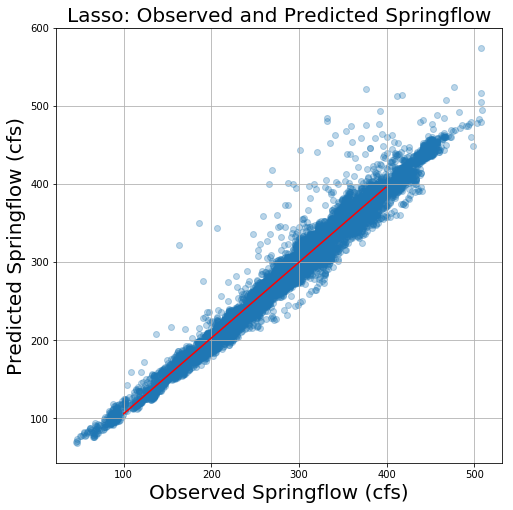

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_list, y_pred_clf, alpha=0.3)
slope, intercept, r_value, p_value, std_err = linregress(y_list, y_pred_clf)
print("Slope: ", slope)
print("Intercept: ", intercept)
print("R Value: ", r_value)
print("P Value: ", p_value)
regx = np.arange(100,400)
regy = slope*regx + intercept
ax.plot(regx,regy,color='r')

ax.set_title('Lasso: Observed and Predicted Springflow', size=20)
ax.set_ylabel("Predicted Springflow (cfs)", size=20)
ax.set_xlabel("Observed Springflow (cfs)", size=20)
ax.grid()
plt.savefig(os.path.join("..", "..", "img", "Springflow_pred_obs.png"))
plt.show()

Slope:  1.0042737760500122
Intercept:  1.7001231145990232
R Value:  0.9716284905644994
P Value:  0.0


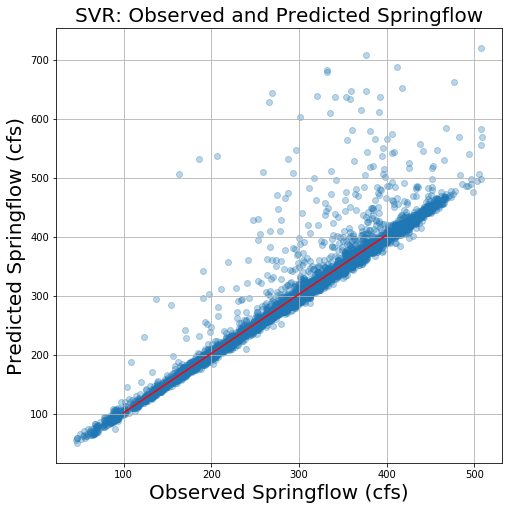

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_list, y_pred_svr, alpha=0.3)
slope, intercept, r_value, p_value, std_err = linregress(y_list, y_pred_svr)
print("Slope: ", slope)
print("Intercept: ", intercept)
print("R Value: ", r_value)
print("P Value: ", p_value)
regx = np.arange(100,400)
regy = slope*regx + intercept
ax.plot(regx,regy,color='r')

ax.set_title('SVR: Observed and Predicted Springflow', size=20)
ax.set_ylabel("Predicted Springflow (cfs)", size=20)
ax.set_xlabel("Observed Springflow (cfs)", size=20)
ax.grid()
plt.savefig(os.path.join("..", "..", "img", "svr.png"))
plt.show()

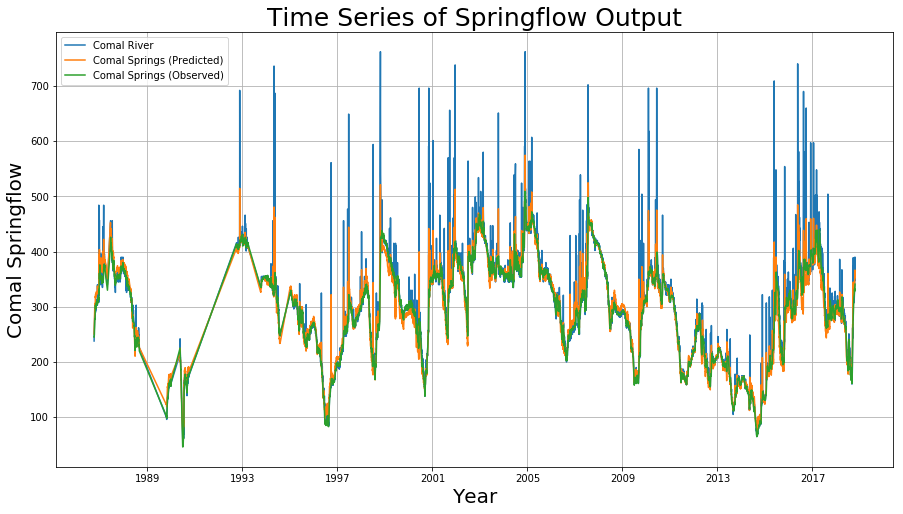

array([250.63700025, 256.42969442, 269.75018097, ..., 341.56526174,
       366.55629281, 352.89248561])

In [14]:
datetime = pd.to_datetime(df.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(datetime, X[:,1],label='Comal River')
ax.plot(datetime,y_pred_clf,label='Comal Springs (Predicted)')
ax.plot(datetime,y_list,label='Comal Springs (Observed)')
ax.set_title('Time Series of Springflow Output', size=25)
ax.set_ylabel("Comal Springflow", size=20)
ax.set_xlabel("Year", size=20)
ax.grid()
ax.legend()
plt.savefig(os.path.join("..", "..", "img", "obs_lasso.png"))
plt.show()
y_pred_clf

In [15]:
def get_change(current, previous):
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return 0


percdiff = get_change(y_list, y_pred_clf)
percdiff

array([2.24906947, 4.45724293, 7.32165625, ..., 3.97149923, 7.79042493,
       3.37000251])

# Plot in Bokeh!! (oooooh aaaahhhh)

In [16]:
# from bokeh.models import BoxSelectTool, HoverTool
# from bokeh.plotting import figure, output_file, show, ColumnDataSource

# # Input Data
# x = datetime
# y = y_pred_clf
# y2 = y_list
# y3 = X[:,1]
# y4 = percdiff

# output_file("lasso.html")

# TOOLS = "crosshair, pan,wheel_zoom, box_zoom, reset, box_select"

# plot = figure(tools=TOOLS, plot_width=1200, plot_height=650, title="Springflow Prediction", 
#            x_axis_label='Datetime', y_axis_label='Stream Discharge', x_axis_type="datetime")

# plot1 = plot.line(x, y2, legend="Observed", line_color="red", line_dash="2 2")
# # plot.add_tools(HoverTool(show_arrow=False,renderers=[plot1], tooltips=[('Observed',"$y2")], mode='vline'))

# plot2 = plot.line(x, y, legend="Comal River", line_color="green", line_dash="4 4")
# # plot.add_tools(HoverTool(show_arrow=False,renderers=[plot2], tooltips=[("Predicted","$y")], mode='vline'))

# plot3 = plot.line(x, y3, legend="Lasso Prediction", line_width=.5)
# # plot.add_tools(HoverTool(show_arrow=False,renderers=[plot3], tooltips=[("Streamflow","$y3")], mode='vline'))


# show(plot)

In [17]:
from bokeh.models import BoxSelectTool, HoverTool
from bokeh.layouts import gridplot
from bokeh.layouts import column
from bokeh.plotting import figure, output_file, show, ColumnDataSource

x = datetime
y = y_pred_clf
y2 = y_list
y3 = X[:,1]
y4 = percdiff

TOOLS = "crosshair, pan,wheel_zoom, box_zoom, reset, box_select"
TOOLTIPS = [
    ("Discharge", "$y")
]
output_file("lasso.html")
s1 = figure(plot_width=1200, plot_height=450, title="Springflow Prediction", 
           x_axis_label='Datetime', y_axis_label='Stream Discharge', 
           x_axis_type="datetime", tooltips=TOOLTIPS, tools=TOOLS)

s1.line(x, y, legend="Comal River", line_color="green", line_dash="4 4")
s1.line(x, y2, legend="Observed", line_color="red", line_dash="2 2")
s1.line(x, y3, legend="Lasso Prediction", line_width=.5)

s2 = figure(plot_width=1200, plot_height=200, title="Percent Difference", 
           x_axis_label='Datetime', y_axis_label='Stream Discharge', 
           x_axis_type="datetime", tooltips=TOOLTIPS, tools=TOOLS)

s2.line(x, y4, legend="Percent Difference", line_width=.5, line_color="purple")

# p = gridplot([[s1, s2]])
show(column(s1, s2))